In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import corpus_bleu

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
# to pad text sequences to make all of them the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add,GRU

In [ ]:
DATASET_DIR = 'drive/MyDrive/Colab Data/Datasets/flickr8.zip'
FEATURES_DIR = 'drive/MyDrive/Resnet/features.zip'

In [ ]:
# Load ResNet50 model
model = ResNet50()
# remove last layer of model because we only need the previous layers that extract image features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
with ZipFile(FEATURES_DIR, 'r') as zip_ref:
    zip_ref.extract("features.pkl", path='drive/MyDrive/Resnet')

In [ ]:
# load features from pickle
with open(os.path.join("drive/MyDrive/Resnet", 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

In [ ]:
with open("drive/MyDrive/flickr8k/captions.txt", 'r') as captions_file:
  captions_doc = captions_file.read()

In [ ]:
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')[1:]):
  # split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)

  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption corresponding to image id
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # convert to lowercase
      caption = caption.lower()
      # delete digits, special chars, ...
      caption = caption.replace(r'[^A-Za-z]', '')
      # delete additional spaces
      caption = caption.replace(r'\s+', ' ')
      # add start and end tags to the caption
      caption = " ".join([word for word in caption.split() if len(word)>1])
      caption = 'startseq ' + caption + ' endseq'
      captions[i] = caption

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence (one-hot encoding)
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        # give the batch inputs and outputs to the model
        yield [X1, X2], y
        # reinitialize the batch inputs for the next batch
        X1, X2, y = list(), list(), list()
        n = 0

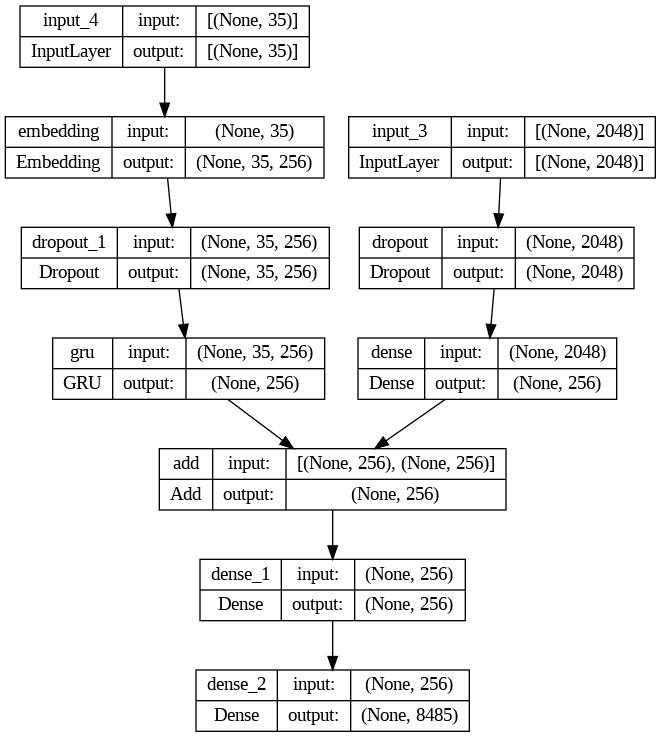

In [ ]:
# ENCODER MODEL
# Image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# DECODER MODEL
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# WHOLE MODEL
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# plot the model
plot_model(model, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 56s 497ms/step - loss: 2.2341


In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with highest probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += ' ' + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  # append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# calculate BLEU score (n-gram)
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')
print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.334, 0.333, 0.333, 0))}')
print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}')

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5583333333333333
BLEU-2: 0.33305794882026557
BLEU-3: 0.2057340471019451
BLEU-4: 0.12464527428475475
